In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import warnings

warnings.filterwarnings("ignore")
plt.style.use("default")


In [2]:
DATA_PATH = r"C:\Users\Kej\OneDrive\Documents\PROJECTS\TimeSeries_NLP_MiniProject\data\customer_support_data.csv"

df = pd.read_csv(DATA_PATH)
print(df.shape)
df.head()


(85907, 20)


,Unique id,channel_name,category,Sub-category,Customer Remarks,Order_id,order_date_time,Issue_reported at,issue_responded,Survey_response_Date,Customer_City,Product_category,Item_price,connected_handling_time,Agent_name,Supervisor,Manager,Tenure Bucket,Agent Shift,CSAT Score
0,7e9ae164-6a8b-4521-a2d4-58f7c9fff13f,Outcall,Product Queries,Life Insurance,NaN,c27c9bb4-fa36-4140-9f1f-21009254ffdb,NaN,01-08-2023 11:13,01-08-2023 11:47,01-Aug-23,NaN,NaN,NaN,NaN,Richard Buchanan,Mason Gupta,Jennifer Nguyen,On Job Training,Morning,5
1,b07ec1b0-f376-43b6-86df-ec03da3b2e16,Outcall,Product Queries,Product Specific Information,NaN,d406b0c7-ce17-4654-b9de-f08d421254bd,NaN,01-08-2023 12:52,01-08-2023 12:54,01-Aug-23,NaN,NaN,NaN,NaN,Vicki Collins,Dylan Kim,Michael Lee,>90,Morning,5
2,200814dd-27c7-4149-ba2b-bd3af3092880,Inbound,Order Related,Installation/demo,NaN,c273368d-b961-44cb-beaf-62d6fd6c00d5,NaN,01-08-2023 20:16,01-08-2023 20:38,01-Aug-23,NaN,NaN,NaN,NaN,Duane Norman,Jackson Park,William Kim,On Job Training,Evening,5
3,eb0d3e53-c1ca-42d3-8486-e42c8d622135,Inbound,Returns,Reverse Pickup Enquiry,NaN,5aed0059-55a4-4ec6-bb54-97942092020a,NaN,01-08-2023 20:56,01-08-2023 21:16,01-Aug-23,NaN,NaN,NaN,NaN,Patrick Flores,Olivia Wang,John Smith,>90,Evening,5
4,ba903143-1e54-406c-b969-46c52f92e5df,Inbound,Cancellation,Not Needed,NaN,e8bed5a9-6933-4aff-9dc6-ccefd7dcde59,NaN,01-08-2023 10:30,01-08-2023 10:32,01-Aug-23,NaN,NaN,NaN,NaN,Christopher Sanchez,Austin Johnson,Michael Lee,0-30,Morning,5


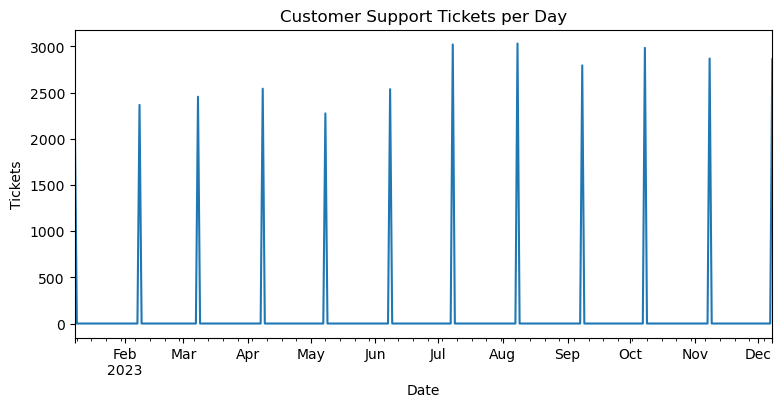

In [3]:
df['Issue_reported at'] = pd.to_datetime(df['Issue_reported at'], errors='coerce')
df = df.dropna(subset=['Issue_reported at'])

ts = df.groupby(df['Issue_reported at'].dt.date).size()
ts.index = pd.to_datetime(ts.index)
ts = ts.asfreq('D', fill_value=0)

ts.plot(figsize=(9,4), title="Customer Support Tickets per Day")
plt.xlabel("Date")
plt.ylabel("Tickets")
plt.show()


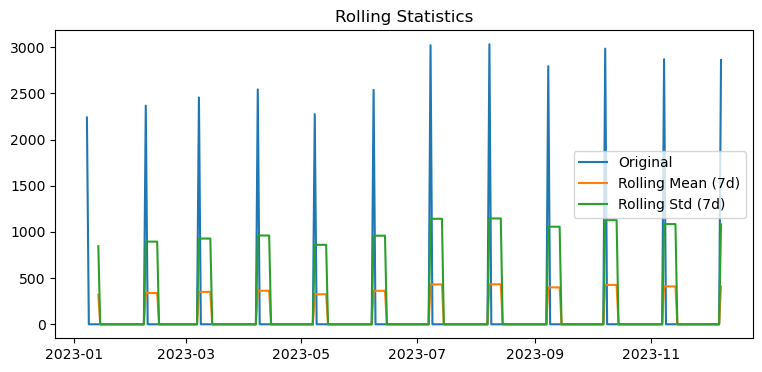

In [4]:
rolling_mean = ts.rolling(7).mean()
rolling_std = ts.rolling(7).std()

plt.figure(figsize=(9,4))
plt.plot(ts, label="Original")
plt.plot(rolling_mean, label="Rolling Mean (7d)")
plt.plot(rolling_std, label="Rolling Std (7d)")
plt.legend()
plt.title("Rolling Statistics")
plt.show()


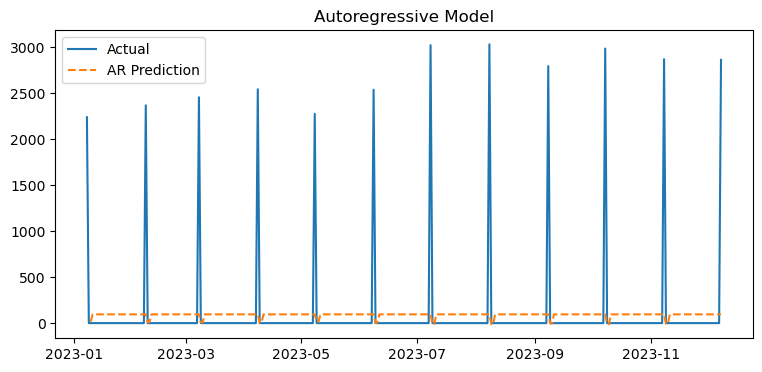

In [5]:
from statsmodels.tsa.ar_model import AutoReg

ar_model = AutoReg(ts, lags=2, old_names=False).fit()
ar_pred = ar_model.predict(start=0, end=len(ts)-1)

plt.figure(figsize=(9,4))
plt.plot(ts, label="Actual")
plt.plot(ar_pred, label="AR Prediction", linestyle="--")
plt.legend()
plt.title("Autoregressive Model")
plt.show()


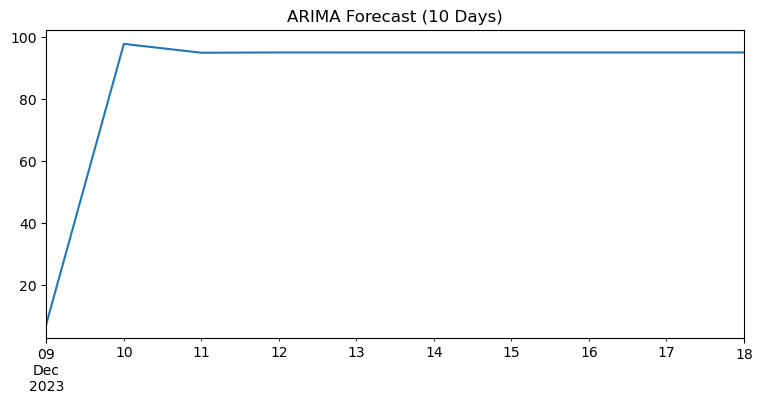

In [6]:
from statsmodels.tsa.arima.model import ARIMA

arima = ARIMA(ts, order=(1,1,1)).fit()
forecast_arima = arima.forecast(10)

forecast_arima.plot(title="ARIMA Forecast (10 Days)", figsize=(9,4))
plt.show()


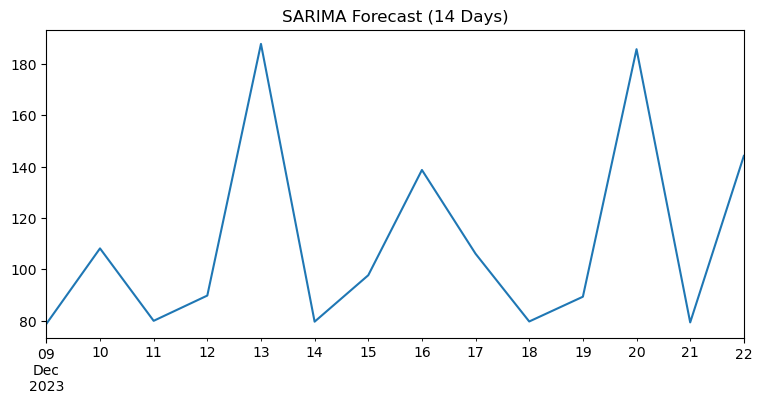

In [7]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima = SARIMAX(
    ts,
    order=(1,1,1),
    seasonal_order=(1,1,1,7),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_fit = sarima.fit()
sarima_forecast = sarima_fit.forecast(14)

sarima_forecast.plot(title="SARIMA Forecast (14 Days)", figsize=(9,4))
plt.show()


In [8]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("stopwords")

sample_text = "My order has not arrived yet and I need help ASAP"
word_tokenize(sample_text.lower())


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Kej\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Kej\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kej\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['my',
 'order',
 'has',
 'not',
 'arrived',
 'yet',
 'and',
 'i',
 'need',
 'help',
 'asap']

In [9]:
import sys
!{sys.executable} -m spacy download en_core_web_sm
import spacy
nlp = spacy.load("en_core_web_sm", disable=["parser", "tagger"])
print("spaCy loaded")


     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
     -- ------------------------------------- 0.8/12.8 MB 3.3 MB/s eta 0:00:04
     ---- ----------------------------------- 1.6/12.8 MB 3.4 MB/s eta 0:00:04
     ------ --------------------------------- 2.1/12.8 MB 3.3 MB/s eta 0:00:04
     -------- ------------------------------- 2.6/12.8 MB 3.0 MB/s eta 0:00:04
     ---------- ----------------------------- 3.4/12.8 MB 3.1 MB/s eta 0:00:03
     ------------- -------------------------- 4.2/12.8 MB 3.2 MB/s eta 0:00:03
     -------------- ------------------------- 4.7/12.8 MB 3.2 MB/s eta 0:00:03
     ---------------- ----------------------- 5.2/12.8 MB 3.1 MB/s eta 0:00:03
     ------------------ --------------------- 5.8/12.8 MB 3.1 MB/s eta 0:00:03
     -------------------- ------------------- 6.6/12.8 MB 3.1 MB/s eta 0:00:03
     ---------------------- ----------------- 7.1/12.8 MB 3.0 MB/s

In [10]:
def clean_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-zA-Z ]", "", text)
    return text

df["clean_text"] = df["Customer Remarks"].apply(clean_text)
df[["Customer Remarks", "clean_text"]].head()


,Customer Remarks,clean_text
0,NaN,
1,NaN,
2,NaN,
3,NaN,
4,NaN,


In [11]:
sample_df = df.sample(300, random_state=42)

def extract_entities(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

sample_df["entities"] = sample_df["clean_text"].apply(extract_entities)
sample_df.head()


,Unique id,channel_name,category,Sub-category,Customer Remarks,Order_id,order_date_time,Issue_reported at,issue_responded,Survey_response_Date,...,Item_price,connected_handling_time,Agent_name,Supervisor,Manager,Tenure Bucket,Agent Shift,CSAT Score,clean_text,entities
29435,241dbd8b-afb1-4689-b11a-9f661aa70629,Inbound,Returns,Return request,NaN,NaN,NaN,2023-12-08 19:29:00,12-08-2023 20:11,12-Aug-23,...,NaN,NaN,Morgan Gomez,Jackson Park,William Kim,On Job Training,Evening,5,,[]
27088,2def83cf-a5e1-4a56-8a19-e6cbc8218cb3,Inbound,Returns,Reverse Pickup Enquiry,U take Maximum time,5dfd3b9a-e594-4133-8476-5186878de3dc,02-08-2023 15:40,2023-11-08 10:18:00,11-08-2023 14:27,11-Aug-23,...,649.0,NaN,Shirley Hayden,Scarlett Chen,John Smith,0-30,Morning,5,u take maximum time,[]
14094,cedb8b0b-aae7-4167-9c93-305921c66404,Inbound,Order Related,Installation/demo,Tv sound not working,36dcc2fd-1b19-4bb4-8076-f60ec4f3786d,NaN,2023-05-08 14:47:00,05-08-2023 15:09,05-Aug-23,...,NaN,NaN,Mackenzie Phillips,Emma Park,John Smith,31-60,Morning,1,tv sound not working,[]
27162,e71fd0d0-a9a8-497a-ba0e-304f83719c18,Inbound,Offers & Cashback,Other Cashback,NaN,NaN,NaN,2023-12-08 18:47:00,12-08-2023 18:48,12-Aug-23,...,NaN,NaN,Richard Oconnor,Mia Yamamoto,Emily Chen,0-30,Evening,5,,[]
18278,3f0b0a76-946f-4772-bafa-f1b323213ed3,Inbound,Returns,Reverse Pickup Enquiry,NaN,41d3d772-927b-435f-a820-f8edfe33450f,25-07-2023 20:10,2023-09-08 14:15:00,09-08-2023 14:17,09-Aug-23,...,603.0,NaN,Jennifer May,Zoe Yamamoto,William Kim,On Job Training,Morning,5,,[]


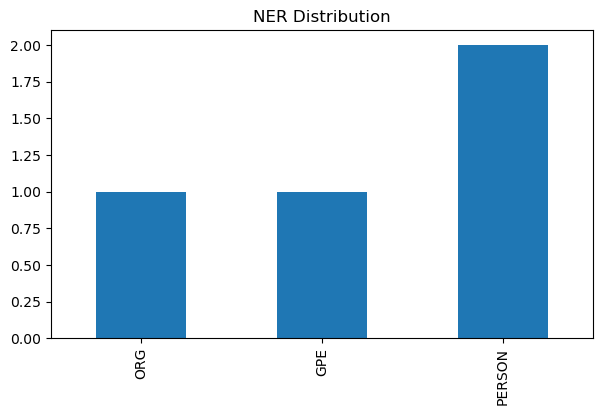

In [12]:
from collections import Counter

entities = [ent for row in sample_df["entities"] for ent in row]

if entities:
    labels = [e[1] for e in entities]
    pd.Series(Counter(labels)).plot(kind="bar", figsize=(7,4), title="NER Distribution")
    plt.show()
else:
    print("No entities detected")


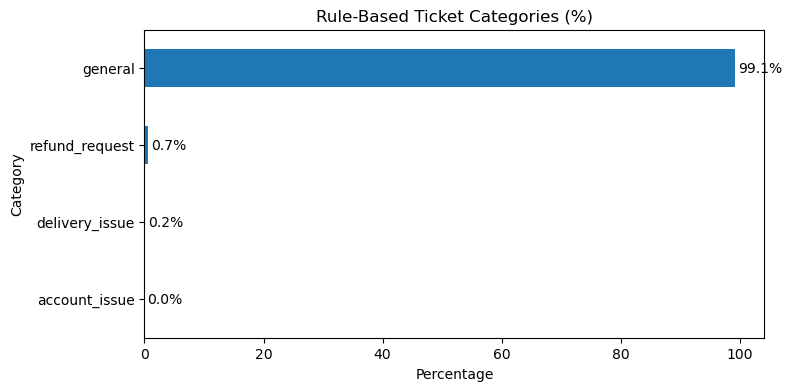

In [19]:
import matplotlib.pyplot as plt

counts = df["rule_label"].value_counts(normalize=True) * 100

plt.figure(figsize=(8,4))
counts.sort_values().plot(kind="barh")

for i, v in enumerate(counts.sort_values()):
    plt.text(v + 0.5, i, f"{v:.1f}%", va='center')

plt.title("Rule-Based Ticket Categories (%)")
plt.xlabel("Percentage")
plt.ylabel("Category")
plt.show()


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

X = df["clean_text"]
y = df["rule_label"]

vectorizer = TfidfVectorizer(max_features=3000)
X_vec = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2)

nb = MultinomialNB()
nb.fit(X_train, y_train)

nb_acc = nb.score(X_test, y_test)
print("Naive Bayes Accuracy:", nb_acc)


Naive Bayes Accuracy: 0.9909304143862393


In [15]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

lr_acc = lr.score(X_test, y_test)
print("Logistic Regression Accuracy:", lr_acc)


Logistic Regression Accuracy: 0.9951524628616106


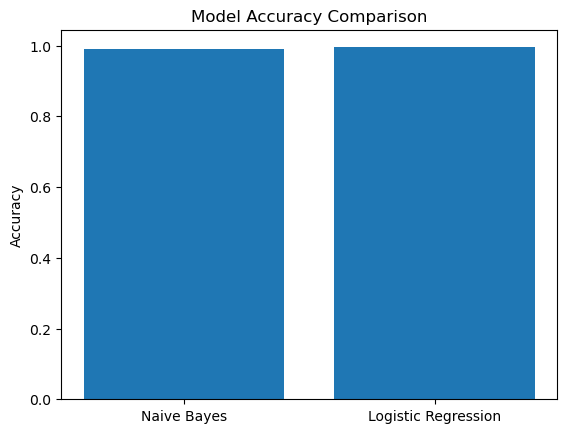

In [16]:
plt.bar(["Naive Bayes", "Logistic Regression"], [nb_acc, lr_acc])
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.show()


In [17]:
def genai_summary(text):
    return f"This ticket mainly relates to: {rule_based_label(text)}"

df["genai_summary"] = df["clean_text"].apply(genai_summary)
df[["clean_text", "genai_summary"]].head()


,clean_text,genai_summary
0,,This ticket mainly relates to: general
1,,This ticket mainly relates to: general
2,,This ticket mainly relates to: general
3,,This ticket mainly relates to: general
4,,This ticket mainly relates to: general


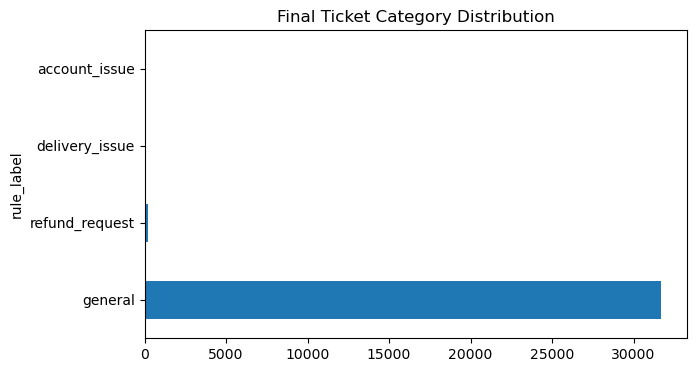

In [18]:
df["rule_label"].value_counts().plot(
    kind="barh", figsize=(7,4),
    title="Final Ticket Category Distribution"
)
plt.show()
